In [27]:
from collections.abc import Callable
from functools import partial

import jax
import jax.numpy as jnp
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import astropy.constants as const
from astropy.modeling.models import BlackBody
import astropy.units as u

from Phase_curve_v1 import luminosity_bb

from jaxoplanet.starry.orbit import SurfaceSystem
from jaxoplanet.orbits.keplerian import Central, Body
from jaxoplanet.types import Array, Scalar
from jaxoplanet.core.limb_dark import light_curve as _limb_dark_light_curve
from jaxoplanet.starry.core.basis import A1, A2_inv, U
from jaxoplanet.starry.core.polynomials import Pijk
from jaxoplanet.starry.core.rotation import left_project
from jaxoplanet.starry.core.solution import rT, solution_vector
from jaxoplanet.starry.surface import Surface
from jaxoplanet.starry.system_observable import system_observable

In [70]:
def surface_light_curve(
    surface: Surface,
    r: float | None = None,
    x: float | None = None,
    y: float | None = None,
    z: float | None = None,
    theta: float | None = None,
    order: int = 20,
    higher_precision: bool = False,
):
    """Light curve of an occulted surface.

    Args:
        surface (Surface): Surface object
        r (float or None): radius of the occulting body, relative to the current map
           body
        x (float or None): x coordinate of the occulting body relative to the surface
           center. By default (None) 0.0
        y (float or None): y coordinate of the occulting body relative to the surface
           center. By default (None) 0.0
        z (float or None): z coordinate of the occulting body relative to the surface
           center. By default (None) 0.0
        theta (float):
            rotation angle of the map, in radians. By default 0.0
        order (int):
            order of the P integral numerical approximation. By default 20
        higher_precision (bool): whether to compute change of basis matrix as hight
            precision. By default False (only used to testing).

    Returns:
        ArrayLike: flux
    """
    if higher_precision:
        try:
            from jaxoplanet.starry.multiprecision import (
                basis as basis_mp,
                utils as utils_mp,
            )
        except ImportError as e:
            raise ImportError(
                "The `mpmath` Python package is required for higher_precision=True."
            ) from e

    total_deg = surface.deg

    rT_deg = rT(total_deg)

    x = 0.0 if x is None else x
    y = 0.0 if y is None else y
    z = 0.0 if z is None else z

    # no occulting body
    if r is None:
        b_rot = True
        theta_z = 0.0
        design_matrix_p = rT_deg

    # occulting body
    else:
        b = jnp.sqrt(jnp.square(x) + jnp.square(y))
        b_rot = jnp.logical_or(jnp.greater_equal(b, 1.0 + r), jnp.less_equal(z, 0.0))
        b_occ = jnp.logical_not(b_rot)

        # trick to avoid nan `x=jnp.where...` grad caused by nan sT
        r = jnp.where(b_rot, 1.0, r)
        b = jnp.where(b_rot, 1.0, b)

        if surface.ydeg == 0:
            if surface.udeg == 0:
                ld_u = jnp.array([])
            else:
                ld_u = jnp.concatenate(
                    [jnp.atleast_1d(jnp.asarray(u_)) for u_ in surface.u], axis=0
                )

            lc_func = partial(_limb_dark_light_curve, ld_u, order=order)
            lc = lc_func(b, r)
            return surface.amplitude * (1.0 + jnp.where(b_occ, lc, 0))

        else:
            theta_z = jnp.arctan2(x, y)
            sT = solution_vector(total_deg, order=order)(b, r)

        if total_deg > 0:
            if higher_precision:
                A2 = np.atleast_2d(utils_mp.to_numpy(basis_mp.A2(total_deg)))
            else:
                A2 = scipy.sparse.linalg.inv(A2_inv(total_deg))
                A2 = jax.experimental.sparse.BCOO.from_scipy_sparse(A2)
        else:
            A2 = jnp.array([[1]])

        design_matrix_p = jnp.where(b_occ, sT @ A2, rT_deg)

    if surface.ydeg == 0:
        rotated_y = surface.y.todense()
    else:
        rotated_y = left_project(
            surface.ydeg,
            surface._inc,
            surface._obl,
            theta,
            theta_z,
            surface.y.todense(),
        )

    # limb darkening
    if surface.udeg == 0:
        p_u = Pijk.from_dense(jnp.array([1]))
    else:
        u = jnp.array([1, *surface.u])
        p_u = Pijk.from_dense(u @ U(surface.udeg), degree=surface.udeg)

    # surface map * limb darkening map
    if higher_precision:
        A1_val = np.atleast_2d(utils_mp.to_numpy(basis_mp.A1(surface.ydeg)))
    else:
        A1_val = jax.experimental.sparse.BCOO.from_scipy_sparse(A1(surface.ydeg))

    p_y = Pijk.from_dense(A1_val @ rotated_y, degree=surface.ydeg)
    p_yu = p_y * p_u
    norm = np.pi / (p_u.tosparse() @ rT(surface.udeg))

    return surface.amplitude * (p_yu.tosparse() @ design_matrix_p) * norm

def system_observable(surface_observable, **kwargs):
    _surface_observable = partial(surface_observable, **kwargs)

    def observable_fun(
        system: SurfaceSystem,
    ) -> Callable[[Scalar], tuple[Array | None, Array | None]]:
        # the observable function of the central given the position and radii
        # of all other bodies
        central_bodies_observable = jax.vmap(
            _surface_observable, in_axes=(None, 0, 0, 0, 0, None)
        )

        # the observable function of all bodies combined given their position to the
        # central
        @partial(system.surface_vmap, in_axes=(0, 0, 0, 0, None))
        def compute_body_observable(surface, radius, x, y, z, time):
            if surface is None:
                return 0.0
            else:
                theta = surface.rotational_phase(time)
                return _surface_observable(
                    surface,
                    (system.central.radius / radius),
                    (x / radius),
                    (y / radius),
                    (z / radius),
                    theta,
                )

        @partial(jnp.vectorize, signature="()->(n)")
        def observable_impl(time: Scalar) -> Array:
            # a function that give the array of observables for all bodies, starting
            # with the central
            if system.central_surface is None:
                central_light_curves = jnp.array([0.0])
            else:
                theta = system.central_surface.rotational_phase(time)
                central_radius = system.central.radius
                central_phase_curve = _surface_observable(
                    system.central_surface, theta=theta
                )
                if len(system.bodies) > 0:
                    xos, yos, zos = system.relative_position(time)
                    n = len(xos)
                    central_light_curves = central_bodies_observable(
                        system.central_surface,
                        (system.radius / central_radius),
                        (xos / central_radius),
                        (yos / central_radius),
                        (zos / central_radius),
                        theta,
                    )

                    if n > 1 and central_light_curves is not None:
                        central_light_curves = central_light_curves.sum(
                            0
                        ) - central_phase_curve * (n - 1)
                        central_light_curves = jnp.expand_dims(central_light_curves, 0)

                    body_light_curves = compute_body_observable(
                        system.radius, -xos, -yos, -zos, time
                    )

                    return jnp.hstack([central_light_curves, body_light_curves])
                else:
                    return jnp.array([central_phase_curve])

        return observable_impl

    return observable_fun

def system_observable_phase(surface_observable, T_planet, T_star, lamb, **kwargs):
    _surface_observable = partial(surface_observable, **kwargs)

    def observable_fun(
        system: SurfaceSystem,
    ) -> Callable[[Scalar], tuple[Array | None, Array | None]]:
        # the observable function of the central given the position and radii
        # of all other bodies
        central_bodies_observable = jax.vmap(
            _surface_observable, in_axes=(None, 0, 0, 0, 0, None)
        )

        # the observable function of all bodies combined given their position to the
        # central
        @partial(system.surface_vmap, in_axes=(0, 0, 0, 0, None))
        def compute_body_observable(surface, radius, x, y, z, time):
            if surface is None:
                return 0.0
            else:
                theta = surface.rotational_phase(time)
                return _surface_observable(
                    surface,
                    (system.central.radius / radius),
                    (x / radius),
                    (y / radius),
                    (z / radius),
                    theta,
                )

        @partial(jnp.vectorize, signature="()->(n)")
        def observable_impl(time: Scalar) -> Array:
            # a function that give the array of observables for all bodies, starting
            # with the central
            if system.central_surface is None:
                central_light_curves = jnp.array([0.0])
            else:
                theta = system.central_surface.rotational_phase(time)
                central_radius = system.central.radius
                central_phase_curve = _surface_observable(
                    system.central_surface, theta=theta
                )
                if len(system.bodies) > 0:
                    xos, yos, zos = system.relative_position(time)
                    n = len(xos)
                    central_light_curves = central_bodies_observable(
                        system.central_surface,
                        (system.radius / central_radius),
                        (xos / central_radius),
                        (yos / central_radius),
                        (zos / central_radius),
                        theta,
                    )
                    def phase_planet(time,P,t0=0):
                        phase = jnp.sin(((time+t0)/P)*2*jnp.pi - jnp.pi/2)/2+0.5 
                        return phase
                    if n > 1 and central_light_curves is not None:
                        central_light_curves = central_light_curves.sum(
                            0
                        ) - central_phase_curve * (n - 1)
                        central_light_curves = jnp.expand_dims(central_light_curves, 0)

                    body_light_curves = compute_body_observable(
                        system.radius, -xos, -yos, -zos, time
                    )
                    flux_star = BlackBody(T_star * u.K)(lamb * u.micron)
                    flux_planet = BlackBody(T_planet * u.K)(lamb * u.micron)
                    in_eclipse = jnp.logical_not(body_light_curves)
                    #for planet in system.bodies :
                    body_light_curves2 = (flux_planet.value/flux_star.value)*phase_planet(time,system.bodies[0].period)*(system.bodies[0].radius/system.central.radius)**2 * (-1*in_eclipse+1) 
                    return jnp.hstack([central_light_curves, body_light_curves2])
                else:
                    return jnp.array([central_phase_curve])

        return observable_impl

    return observable_fun

def system_observable_phase_multiple_planets(surface_observable, T_planet, T_star, lamb, **kwargs):
    _surface_observable = partial(surface_observable, **kwargs)

    def observable_fun(
        system: SurfaceSystem,
    ) -> Callable[[Scalar], tuple[Array | None, Array | None]]:
        # the observable function of the central given the position and radii
        # of all other bodies
        central_bodies_observable = jax.vmap(
            _surface_observable, in_axes=(None, 0, 0, 0, 0, None)
        )

        # the observable function of all bodies combined given their position to the
        # central
        @partial(system.surface_vmap, in_axes=(0, 0, 0, 0, None))
        def compute_body_observable(surface, radius, x, y, z, time):
            if surface is None:
                return 0.0
            else:
                theta = surface.rotational_phase(time)
                return _surface_observable(
                    surface,
                    (system.central.radius / radius),
                    (x / radius),
                    (y / radius),
                    (z / radius),
                    theta,
                )

        @partial(jnp.vectorize, signature="()->(n)")
        def observable_impl(time: Scalar) -> Array:
            # a function that give the array of observables for all bodies, starting
            # with the central
            if system.central_surface is None:
                central_light_curves = jnp.array([0.0])
            else:
                theta = system.central_surface.rotational_phase(time)
                central_radius = system.central.radius
                central_phase_curve = _surface_observable(
                    system.central_surface, theta=theta
                )
                if len(system.bodies) > 0:
                    xos, yos, zos = system.relative_position(time)
                    n = len(xos)
                    central_light_curves = central_bodies_observable(
                        system.central_surface,
                        (system.radius / central_radius),
                        (xos / central_radius),
                        (yos / central_radius),
                        (zos / central_radius),
                        theta,
                    )
                    def phase_planet(time,P,t0=0):
                        phase = jnp.sin(((time+t0)/P)*2*jnp.pi - jnp.pi/2)/2+0.5 
                        return phase
                    if n > 1 and central_light_curves is not None:
                        central_light_curves = central_light_curves.sum(
                            0
                        ) - central_phase_curve * (n - 1)
                        central_light_curves = jnp.expand_dims(central_light_curves, 0)

                    body_light_curves = compute_body_observable(
                        system.radius, -xos, -yos, -zos, time
                    )
                    flux_star = BlackBody(T_star * u.K)(lamb * u.micron)
                    in_eclipse = jnp.logical_not(body_light_curves)
                    for i in range(len(system.bodies)) :
                        flux_planet = BlackBody(T_planet[i] * u.K)(lamb * u.micron)
                        body_light_curves += (flux_planet.value/flux_star.value)*phase_planet(time,system.bodies[i].period)*(system.bodies[i].radius/system.central.radius)**2 * (-1*in_eclipse+1) 
                    body_light_curves = body_light_curves/jnp.max(body_light_curves)
                    return jnp.hstack([central_light_curves, body_light_curves])
                else:
                    return jnp.array([central_phase_curve])

        return observable_impl

    return observable_fun

def light_curve(system, order=20):
    return system_observable(surface_light_curve, order=order)(system)

def light_curve_2(system, T_planet, T_star, lamb, order=20):
    return system_observable_phase(surface_light_curve, T_planet, T_star, lamb, order=order)(system)

def light_curve_3(system, T_planet, T_star, lamb, order=20):
    return system_observable_phase_multiple_planets(surface_light_curve, T_planet, T_star, lamb, order=order)(system)

In [5]:
df = pd.read_pickle("LHS3844b_0.0_1obs.pickle")
data = df['input_parameters']

In [28]:
transit_duration_days = 0.5212/24
P=data['period']
time_transit=2458828.93037
impact_param=0.186
R_star = data['star_radius']
time_transit = 0
e = 0.0
omega = 0.0 # bcs e = 0
i = data['inclination']*np.pi/180
a = 0.00622*149597870700 # a in m
R = data['planet_radius']
lambda_1 = 5.8
lambda_2 = 6.1
lamb = 5.96
T_star = data['star_temperature']
L_star = luminosity_bb(T_star, lambda_1, lambda_2)
flux_star = BlackBody(T_star * u.K)(lamb * u.micron)
T_planet = data['dayside_temperature']
L = luminosity_bb(T_planet, lambda_1, lambda_2)
flux_planet = BlackBody(T_planet * u.K)(lamb * u.micron)

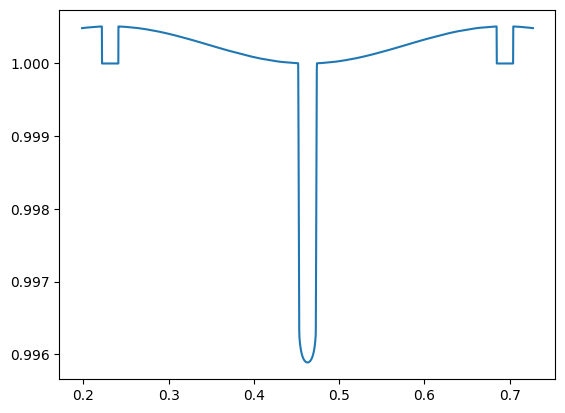

In [73]:
star = Central(radius=R_star, mass=0.1579090)
planet = Body(radius=(R * const.R_earth).to(const.R_sun).value, time_transit=0.0, period=P)
uu = [0.1, 0.06]  # Quadratic limb-darkening coefficients
m = Surface(u=uu)
system = SurfaceSystem(star, m).add_body(planet, m)
model_time = df['data'][lamb]['model']['time'] - 2460000

eclipses = light_curve(system)(model_time)[:,1]
transit = light_curve(system)(model_time)[:,0]
in_eclipse = ~np.array(eclipses, dtype='int')+2

pc_2 = light_curve_2(system, T_planet, T_star, lamb)(model_time)[:,1] + light_curve_2(system, T_planet, T_star, lamb)(model_time)[:,0]
pc_3 = light_curve_3(system, [T_planet], T_star, lamb)(model_time)[:,1] + light_curve_3(system, [T_planet], T_star, lamb)(model_time)[:,0]
pc_3 = pc_3/np.max(pc_3)


def phase_planet(t,P,t0=0):
    """
    Determines the phase of a planet at a given time.

    :param t: the time (in days)
    :type t: float

    :param P: the orbital period (in days)
    :type P: float

    :param t0: the reference time (in days)
    :type t0: float

    :return: phase
    :rtype: float
    """

    phase = np.sin(((t+t0)/P)*2*np.pi - np.pi/2)/2+0.5 # equation 15
    return phase

curve = (flux_planet/flux_star)*phase_planet(model_time,P)*((R * const.R_earth).to(const.R_sun).value/R_star)**2 * (-1*in_eclipse+1) 
full_pc = curve + transit

plt.figure()
#plt.plot(model_time, transit)
#plt.plot(model_time, curve)
#plt.plot(model_time, eclipses)
#plt.plot(model_time, (~np.array(eclipses, dtype='int'))+2)
#plt.plot(model_time, full_pc)
plt.plot(model_time, pc_2)
#plt.plot(model_time, pc_3)
#plt.plot(model_time, in_eclipse)
#plt.plot(model_time, (eclipses+transit)/np.max(eclipses+transit))
plt.show()